# Black Holes
This notebook looks at some quantites of black holes. Namely, we're interested in how the mass fraction of a simple stellar population changes as we increase the total mass of stars formed.

This also shows off how you can do integrals with an upper limit of infinity, just pass `math.inf` or `np.inf`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pimf import (
    PowerLawIMF,          # IMF for Pop III
    ChabrierIMF,          # IMF for Pop II
    LognormalIMF,         # alt. Pop III
    GeneralisedGammaIMF,  # alt. Pop III
    )

In [2]:
def BH_mass_fraction(imf, Mmax, Minitial, Mremnant):
    return imf(Mmax).integrate_linear_piecewise_interpolated_product(25, Mmax, Minitial, Mremnant, extrapolate_grid=True)

def number_of_BHs(imf, Mmax, Minitial, BH_flag):
    return imf(Mmax).integrate_linear_piecewise_interpolated_product(25, Mmax, Minitial, BH_flag, extrapolate_grid=True)

def plot(stellar_model,
         *imfs,
         include_PISN_mass_gap=False,
         maximum_masses=np.geomspace(25, 1e6, 100),
         imf_labels=None):

    Minitial = stellar_model["Minitial"]
    Mremnant = stellar_model["Mremnant"]
    BH_flag = stellar_model["BH_flag"]

    fig, (mass_ax, number_ax) = plt.subplots(1, 2, figsize=(12, 4))

    if imf_labels is None:
        imf_labels = [None] * len(imfs)

    for i, (imf, label) in enumerate(zip(imfs, imf_labels)):
        mass_ax.semilogx(maximum_masses, [BH_mass_fraction(imf, Mmax, Minitial, Mremnant) for Mmax in maximum_masses], label=label)
        number_ax.semilogx(maximum_masses, [number_of_BHs(imf, Mmax, Minitial, BH_flag) for Mmax in maximum_masses], label=label)
        # As an extreme, what is the behaviour as Mmax -> infinity
        mass_ax.axhline(BH_mass_fraction(imf, np.inf, Minitial, Mremnant), color=f"C{i}", linestyle="dotted")
        number_ax.axhline(number_of_BHs(imf, np.inf, Minitial, BH_flag), color=f"C{i}", linestyle="dotted")

    # PISN mass-gap
    if include_PISN_mass_gap:
        mass_ax.axvspan(120, 240, alpha=0.1)
        number_ax.axvspan(120, 240, alpha=0.1)

    mass_ax.set_xlabel("Maximum IMF Mass / $M_\odot$")
    mass_ax.set_ylabel("BH Mass Fraction")
    number_ax.set_xlabel("Maximum IMF Mass / $M_\odot$")
    number_ax.set_ylabel("Number of BHs / $M_\odot$")

    if any(imf_labels):
        plt.legend()
    plt.tight_layout()
    plt.show()

## Population II
Here we follow a simple model that is somewhat popular. 
1. Stars below 25 solar masses do not form black holes.
2. Stars above 25 solar masses form black holes.
3. For stars above 100 solar masses the mass loss is so extreme they have the same end of life as a 120Msol star

We will use remnant masses from [NuGrid](https://nugrid.github.io) for stars 25Msol and below, and [Limongi & Chieffi (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJS..237...13L/abstract)/[Roberti+ (2024)]() for stars above this, interpolating through metallicity.

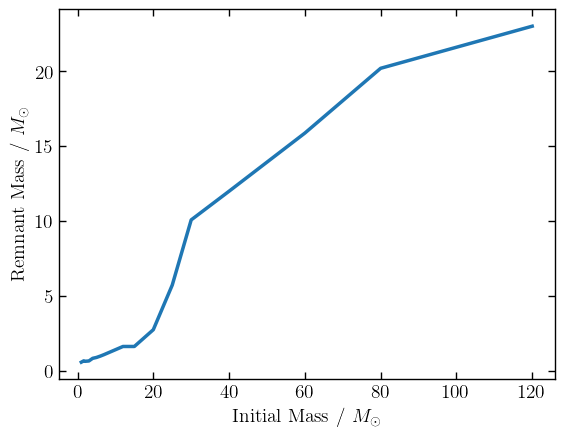

In [3]:
# To use our assumption all stars above 120Msol have same behaviour, we repeat this last value with an initial mass of infinity
Minitial = np.array([  1.  ,   1.65,   2.  ,   3.  ,   4.  ,   5.  ,
                       6.  ,   7.  ,  12.  ,  15.  ,  20.  ,  25.  ,
                      30.  ,  40.  ,  60.  ,  80.  , 120.  , np.inf])

Mremnant = np.array([  0.5601    ,  0.651     ,  0.6201    ,  0.642     ,  0.818     ,  0.8768    ,
                       0.9653    ,  1.066     ,  1.61      ,  1.61      ,  2.73      ,  5.71      ,
                      10.06520636, 11.98206852, 15.86515635, 20.19289124, 23.00549006, 23.00549006])

# Create an array of 1 if a BH is formed, and 0 otherwise.
BH_flag = np.logical_and(Mremnant > 0, Minitial >= 25).astype(int)

popII_stellar_model = {
    "Minitial": Minitial,
    "Mremnant": Mremnant,
    "BH_flag": BH_flag
}

plt.plot(Minitial, Mremnant)
plt.xlabel("Initial Mass / $M_\odot$")
plt.ylabel("Remnant Mass / $M_\odot$")
plt.show()

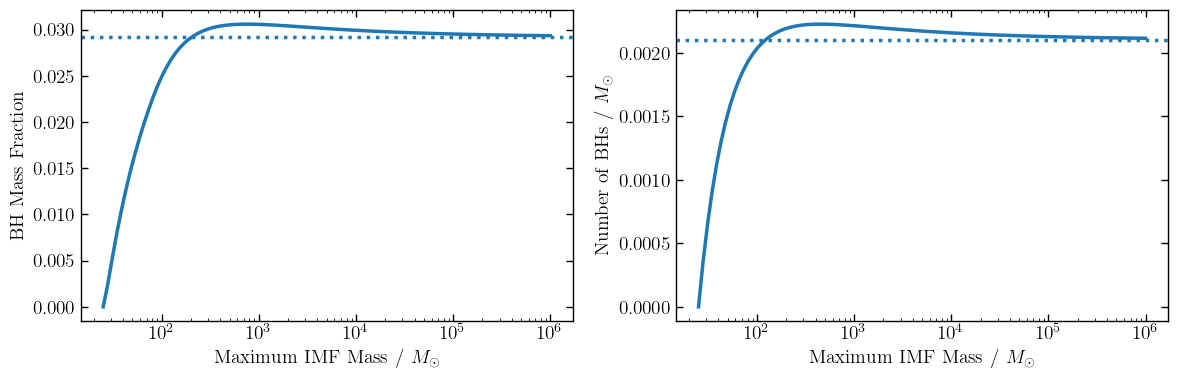

In [4]:
def popII_imf(Mmax=np.inf):
    return ChabrierIMF(Mmax=Mmax, normalisation="mass")

plot(
    popII_stellar_model,
    popII_imf
)

## Population III
We will consider the results from [PARSECV2.0](https://ui.adsabs.harvard.edu/abs/2025A%26A...694A.193C/abstract) and their lowest metallicity ($Z = 10^{-11}$) model:
1. Stars up to 25 Solar masses under core-collapse, forming a neutron star
2. Stars between 25 and 100 Solar masses are "Failed Supernovae", and collapse into black holes
3. Stars between 100 and 120 Solar masses are pulsational pair-instability supernova, forming low mass black holes
4. Stars from 120 to 240 Solar masses are pair-instability supernovae, leaving no remanant.
5. Stars above 240 Solar masses directly collapse into black holes.

Below follows some columns from [their model output.](https://stev.oapd.inaf.it/PARSEC/Database/PARSECv2.0_VMS/Z1E-11_Y0.2485_ejecta.zip) (downloads zip file).

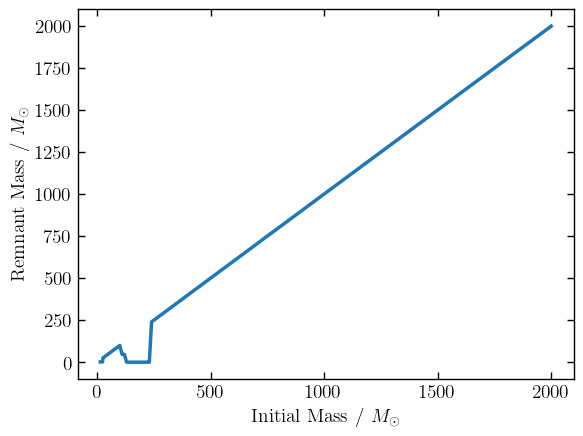

In [5]:
# Z0.00000000001_Y0.2485_total_ejecta.dat
Minitial = np.array([  14.,   16.,   18.,   20.,   22.,   24.,   26.,   28.,   30.,
                       35.,   40.,   50.,   60.,   70.,   80.,   85.,   90.,   95.,
                      100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,  180.,
                      190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,  270.,
                      280.,  290.,  300.,  350.,  400.,  450.,  500.,  550.,  600.,
                      650.,  700.,  750.,  800.,  900., 1000., 1250., 1500., 1750.,
                     2000.])

Mremnant = np.array([1.49550e+00, 1.46074e+00, 1.46122e+00, 1.56980e+00, 1.68152e+00,
                     1.67358e+00, 2.55000e+01, 2.75000e+01, 2.95000e+01, 3.45000e+01,
                     3.95000e+01, 4.95000e+01, 5.95000e+01, 6.95000e+01, 7.95000e+01,
                     8.45000e+01, 8.95000e+01, 9.45000e+01, 9.95000e+01, 4.65835e+01,
                     4.70213e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
                     0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
                     0.00000e+00, 0.00000e+00, 2.39500e+02, 2.49500e+02, 2.59500e+02,
                     2.69500e+02, 2.79500e+02, 2.89500e+02, 2.99500e+02, 3.49499e+02,
                     3.99497e+02, 4.49495e+02, 4.99489e+02, 5.49479e+02, 5.99475e+02,
                     6.49447e+02, 6.99443e+02, 7.49937e+02, 7.99397e+02, 8.99335e+02,
                     9.99310e+02, 1.24892e+03, 1.49836e+03, 1.74795e+03, 1.99676e+03])

# Create an array of 1 if a BH is formed, and 0 otherwise.
BH_flag = np.logical_and(Mremnant > 0, Minitial >= 25).astype(int)

popIII_stellar_model = {
    "Minitial": Minitial,
    "Mremnant": Mremnant,
    "BH_flag": BH_flag
}

# Check we get what we expect compared to Fig. 4 of Costa et al (2024), which described the main PARSECV2.0 data release.
plt.plot(Minitial, Mremnant)
plt.xlabel("Initial Mass / $M_\odot$")
plt.ylabel("Remnant Mass / $M_\odot$")
plt.show()

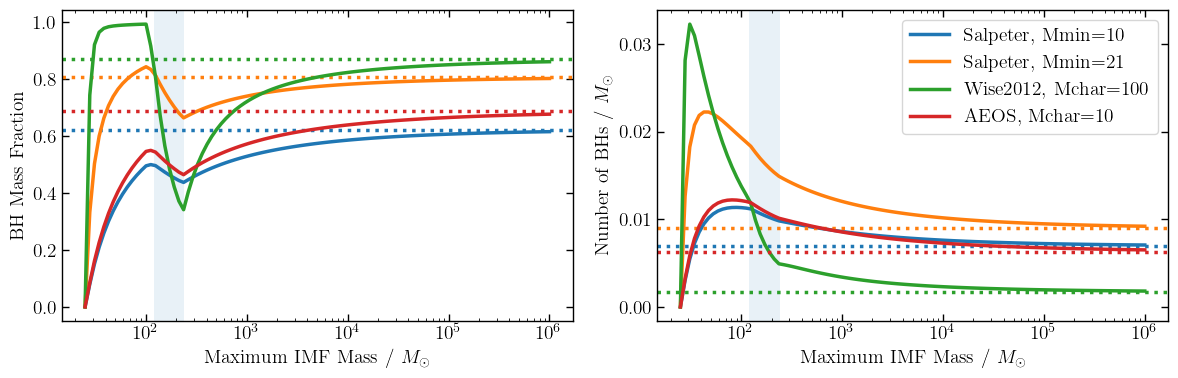

In [6]:
def popIII_imf(Mmax=np.inf):
    return PowerLawIMF(Mmin=10, Mmax=Mmax, normalisation="mass")


plot(
    popIII_stellar_model,
    lambda Mmax: PowerLawIMF(Mmin=10, Mmax=Mmax, normalisation="mass"),
    lambda Mmax: PowerLawIMF(Mmin=21, Mmax=Mmax, normalisation="mass"),
    lambda Mmax: GeneralisedGammaIMF(Mmin=1, mc=100, Mmax=Mmax, normalisation="mass"),
    lambda Mmax: GeneralisedGammaIMF(Mmin=1, mc=10, Mmax=Mmax, normalisation="mass"),
    include_PISN_mass_gap=True,
    imf_labels=["Salpeter, Mmin=10", "Salpeter, Mmin=21", "Wise2012, Mchar=100", "AEOS, Mchar=10"]
)